In [2]:
import pandas as pd

# Load the CSV file
file_path = 'Thunderbird_2k.log_structured.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the DataFrame
print(data.head())


   LineId Label   Timestamp        Date   User Month  Day      Time  \
0       1     -  1131566461  2005.11.09  dn228   Nov    9  12:01:01   
1       2     -  1131566461  2005.11.09  dn228   Nov    9  12:01:01   
2       3     -  1131566461  2005.11.09  dn228   Nov    9  12:01:01   
3       4     -  1131566461  2005.11.09  dn261   Nov    9  12:01:01   
4       5     -  1131566461  2005.11.09  dn261   Nov    9  12:01:01   

      Location        Component     PID  \
0  dn228/dn228  crond(pam_unix)  2915.0   
1  dn228/dn228  crond(pam_unix)  2915.0   
2  dn228/dn228            crond  2916.0   
3  dn261/dn261  crond(pam_unix)  2907.0   
4  dn261/dn261  crond(pam_unix)  2907.0   

                                   Content EventId  \
0             session closed for user root    E117   
1  session opened for user root by (uid=0)    E118   
2  (root) CMD (run-parts /etc/cron.hourly)      E3   
3             session closed for user root    E117   
4  session opened for user root by (uid=0)  

In [3]:
# Check for missing values
print(data.isnull().sum())

# Fill missing values in 'Content' with an empty string or any other strategy
data['Content'] = data['Content'].fillna('')


LineId             0
Label              0
Timestamp          0
Date               0
User               0
Month              0
Day                0
Time               0
Location           0
Component          0
PID              255
Content            0
EventId            0
EventTemplate      0
dtype: int64


In [4]:
data = data.dropna(subset=['PID'])


In [5]:
# Fill missing values with -1
data['PID'] = data['PID'].fillna(-1)

# Alternatively, fill with the mean (if it makes sense)
# mean_pid = data['PID'].mean()
# data['PID'] = data['PID'].fillna(mean_pid)


In [6]:
# Check for missing values again
print(data.isnull().sum())


LineId           0
Label            0
Timestamp        0
Date             0
User             0
Month            0
Day              0
Time             0
Location         0
Component        0
PID              0
Content          0
EventId          0
EventTemplate    0
dtype: int64


In [24]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# Load the CSV file
file_path = 'Thunderbird_2k.log_structured.csv'
data = pd.read_csv(file_path)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(data['Content'], data['Label'], test_size=0.2, random_state=42)

# Initialize the TF-IDF vectorizer
vectorizer = TfidfVectorizer()

# Fit and transform the training log content
X_train_tfidf = vectorizer.fit_transform(X_train)

# Transform the testing log content
X_test_tfidf = vectorizer.transform(X_test)

# Now you can use X_train_tfidf and X_test_tfidf for training and testing your model


In [25]:
from sklearn.ensemble import IsolationForest

# Initialize the Isolation Forest model
model = IsolationForest(contamination=0.1)  # Adjust contamination rate as needed

# Fit the model to the training TF-IDF matrix
model.fit(X_train_tfidf)

# Predict anomalies on the training set
train_anomalies = model.predict(X_train_tfidf)
data.loc[X_train.index, 'Anomaly'] = train_anomalies  # Assign predictions to the original data

# Predict anomalies on the testing set
test_anomalies = model.predict(X_test_tfidf)
data.loc[X_test.index, 'Anomaly'] = test_anomalies  # Assign predictions to the original data


In [26]:
# Count the number of normal and anomalous entries
print(data['Anomaly'].value_counts())

# Optional: Save results to a new CSV file
data.to_csv('anomaly_detection_results.csv', index=False)


Anomaly
 1.0    1819
-1.0     181
Name: count, dtype: int64


In [27]:
# Display anomalous entries for further analysis
anomalies = data[data['Anomaly'] == -1]
print(anomalies[['LineId', 'Content', 'EventId']])


      LineId                                            Content EventId
1          2            session opened for user root by (uid=0)    E118
2          3            (root) CMD (run-parts /etc/cron.hourly)      E3
4          5            session opened for user root by (uid=0)    E118
5          6            (root) CMD (run-parts /etc/cron.hourly)      E3
7          8            session opened for user root by (uid=0)    E118
...      ...                                                ...     ...
1583    1584  jA9JBWEr014256: to=root, ctladdr=root (0/0), d...     E16
1587    1588  jA9JBXgf022479: from=root, size=1594553, class...     E15
1588    1589  jA9JBXgf022479: to=root, ctladdr=root (0/0), d...     E16
1592    1593  jA9JBXVI027337: from=root, size=1597080, class...     E15
1593    1594  jA9JBXVI027337: to=root, ctladdr=root (0/0), d...     E16

[181 rows x 3 columns]


In [28]:
anomaly_counts = anomalies['EventId'].value_counts()
print(anomaly_counts)


EventId
E146    34
E118    19
E37     15
E3      14
E81     11
E111    11
E131    10
E16     10
E40      9
E15      8
E10      7
E38      5
E75      5
E85      5
E36      5
E88      5
E39      3
E35      3
E147     1
E97      1
Name: count, dtype: int64


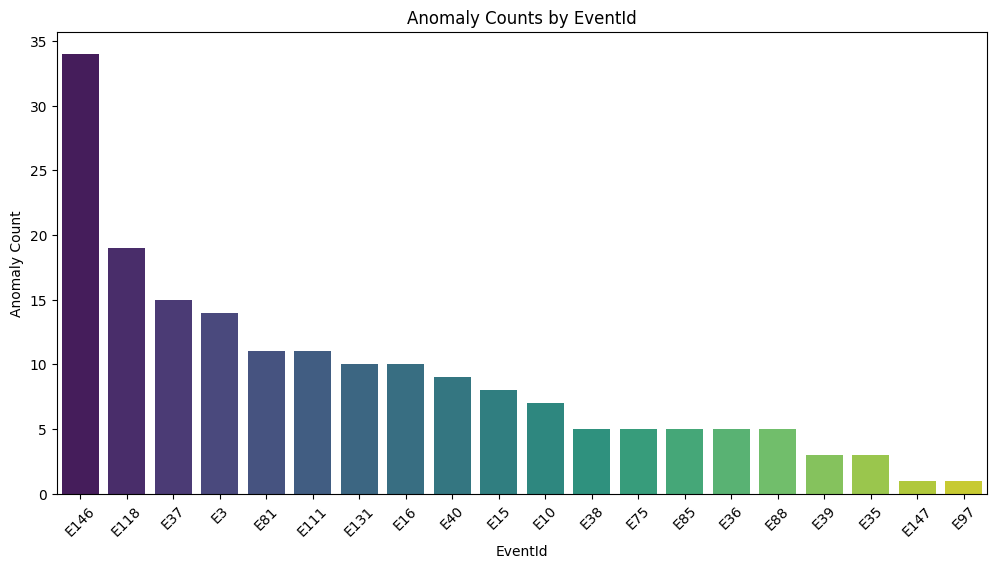

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a bar plot of anomaly counts by EventId
plt.figure(figsize=(12, 6))
sns.barplot(x=anomaly_counts.index, y=anomaly_counts.values, palette='viridis')
plt.title('Anomaly Counts by EventId')
plt.xlabel('EventId')
plt.ylabel('Anomaly Count')
plt.xticks(rotation=45)
plt.show()


In [30]:
# Example to display content for a specific EventId (e.g., E146)
specific_event_anomalies = anomalies[anomalies['EventId'] == 'E146']
print(specific_event_anomalies[['LineId', 'Content', 'Timestamp']])

      LineId                                            Content   Timestamp
1386    1387  Warning: we failed to resolve data source name...  1131567053
1387    1388  Warning: we failed to resolve data source name...  1131567053
1388    1389  Warning: we failed to resolve data source name...  1131567053
1389    1390  Warning: we failed to resolve data source name...  1131567053
1390    1391  Warning: we failed to resolve data source name...  1131567053
1391    1392  Warning: we failed to resolve data source name...  1131567053
1392    1393  Warning: we failed to resolve data source name...  1131567053
1393    1394  Warning: we failed to resolve data source name...  1131567053
1394    1395  Warning: we failed to resolve data source name...  1131567053
1395    1396  Warning: we failed to resolve data source name...  1131567053
1396    1397  Warning: we failed to resolve data source name...  1131567053
1397    1398  Warning: we failed to resolve data source name...  1131567053
1398    1399

/var/folders/ry/tqxg7fpj1yz3wzs610_9tg8w0000gn/T/ipykernel_45539/2672480821.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomalies['Datetime'] = pd.to_datetime(anomalies['Timestamp'], unit='s')


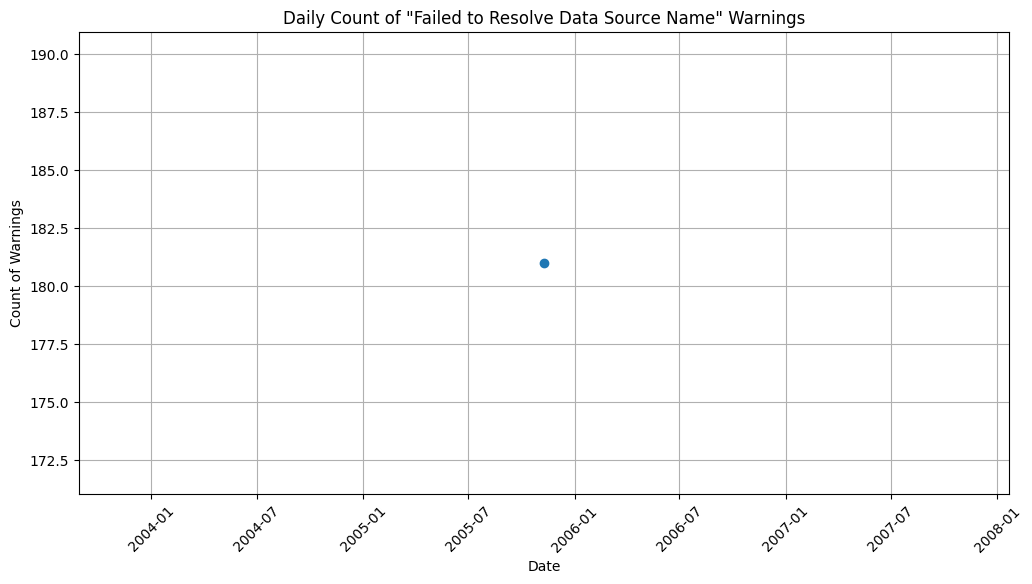

In [31]:
# Convert Timestamp to datetime
anomalies['Datetime'] = pd.to_datetime(anomalies['Timestamp'], unit='s')

# Group by Datetime and count occurrences
warning_counts = anomalies.groupby(anomalies['Datetime'].dt.date).size()

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(warning_counts.index, warning_counts.values, marker='o')
plt.title('Daily Count of "Failed to Resolve Data Source Name" Warnings')
plt.xlabel('Date')
plt.ylabel('Count of Warnings')
plt.xticks(rotation=45)
plt.grid()
plt.show()

Content
session opened for user root by (uid=0)                                                                     19
DHCPDISCOVER from 00:11:43:e3:ba:c3 via eth1: network A_net: no free leases                                 15
(root) CMD (run-parts /etc/cron.hourly)                                                                     14
DHCPREQUEST for 10.100.4.251 (10.100.0.250) from 00:11:43:e3:ba:c3 via eth1: unknown lease 10.100.4.251.     9
DHCPDISCOVER from 00:11:43:e3:ba:c3 via eth1                                                                 5
DHCPOFFER on 10.100.4.251 to 00:11:43:e3:ba:c3 via eth1                                                      5
DHCPREQUEST for 10.100.4.251 (10.100.0.250) from 00:11:43:e3:ba:c3 via eth1                                  3
Physical Processor ID: 0                                                                                     3
DHCPACK on 10.100.4.251 to 00:11:43:e3:ba:c3 via eth1                                                   

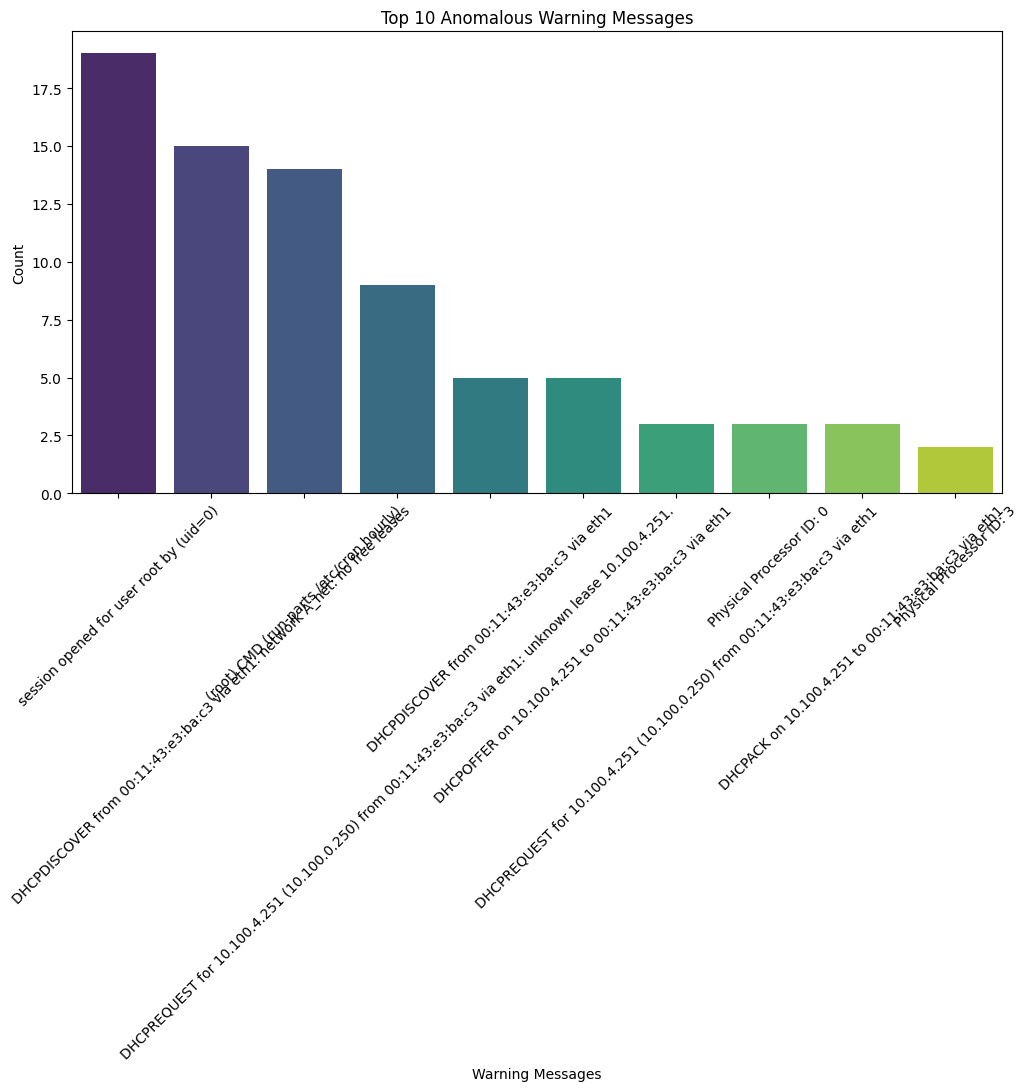

In [32]:
# Count occurrences of each warning message
warning_counts = anomalies['Content'].value_counts()

# Display the top 10 most common warnings
print(warning_counts.head(10))

# You can also visualize the top warnings
plt.figure(figsize=(12, 6))
sns.barplot(x=warning_counts.head(10).index, y=warning_counts.head(10).values, palette='viridis')
plt.title('Top 10 Anomalous Warning Messages')
plt.xlabel('Warning Messages')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

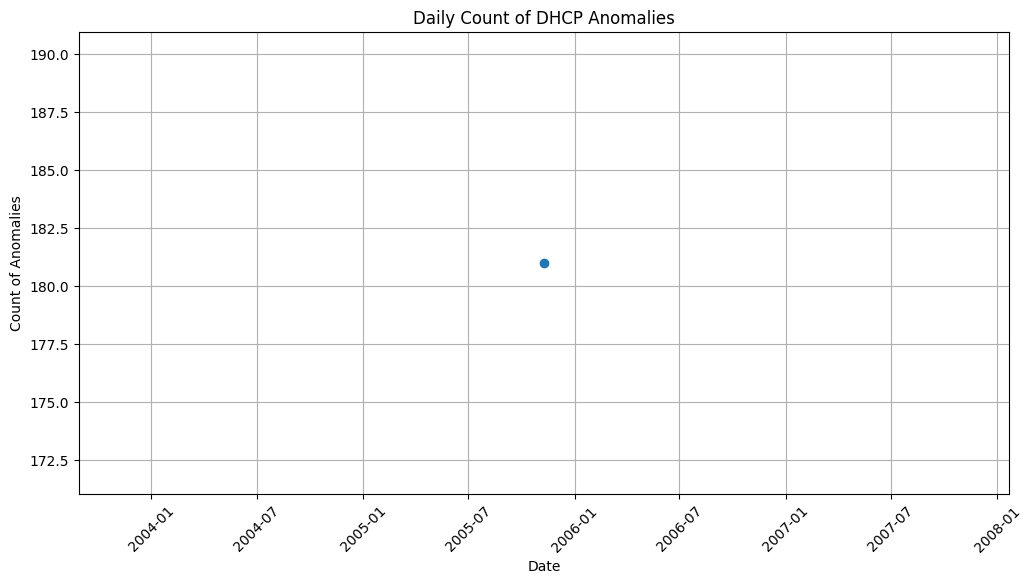

In [33]:
# Group by Datetime to count occurrences
anomalous_datetime_counts = anomalies.groupby(anomalies['Datetime'].dt.date).size()

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(anomalous_datetime_counts.index, anomalous_datetime_counts.values, marker='o')
plt.title('Daily Count of DHCP Anomalies')
plt.xlabel('Date')
plt.ylabel('Count of Anomalies')
plt.xticks(rotation=45)
plt.grid()
plt.show()


In [34]:
import pandas as pd

# Load the CSV file containing the anomalies
file_path = 'anomaly_detection_results.csv'
anomalies = pd.read_csv(file_path)

# Investigate the anomalies further
print(anomalies[['LineId', 'Content', 'EventId', 'Timestamp']].head())

# Group by EventId to see counts
event_counts = anomalies['EventId'].value_counts()
print(event_counts

   LineId                                  Content EventId   Timestamp
0       1             session closed for user root    E117  1131566461
1       2  session opened for user root by (uid=0)    E118  1131566461
2       3  (root) CMD (run-parts /etc/cron.hourly)      E3  1131566461
3       4             session closed for user root    E117  1131566461
4       5  session opened for user root by (uid=0)    E118  1131566461
EventId
E32     819
E125    568
E8       62
E6       62
E7       62
       ... 
E28       1
E137      1
E140      1
E136      1
E34       1
Name: count, Length: 149, dtype: int64


In [35]:
# Detailed view of the most common anomalies
top_anomalies = anomalies[anomalies['EventId'].isin(event_counts.head(5).index)]
print(top_anomalies[['LineId', 'Content', 'EventId', 'Timestamp']])

      LineId                                            Content EventId  \
39        40  data_thread() got not answer from any [Thunder...     E32   
40        41  data_thread() got not answer from any [Thunder...     E32   
41        42  data_thread() got not answer from any [Thunder...     E32   
45        46           synchronized to 10.100.20.250, stratum 3    E125   
46        47           synchronized to 10.100.28.250, stratum 3    E125   
...      ...                                                ...     ...   
1995    1996           synchronized to 10.100.22.250, stratum 3    E125   
1996    1997  data_thread() got not answer from any [Thunder...     E32   
1997    1998           synchronized to 10.100.16.250, stratum 3    E125   
1998    1999           synchronized to 10.100.22.250, stratum 3    E125   
1999    2000           synchronized to 10.100.20.250, stratum 3    E125   

       Timestamp  
39    1131566461  
40    1131566461  
41    1131566461  
45    1131566463  
46  

In [36]:
# Analyze the unique content for the most common anomalies
print(top_anomalies['Content'].unique())

['data_thread() got not answer from any [Thunderbird_A8] datasource'
 'data_thread() got not answer from any [Thunderbird_B8] datasource'
 'data_thread() got not answer from any [Thunderbird_C5] datasource'
 'synchronized to 10.100.20.250, stratum 3'
 'synchronized to 10.100.28.250, stratum 3'
 'synchronized to 10.100.24.250, stratum 3'
 'data_thread() got not answer from any [Thunderbird_B7] datasource'
 'synchronized to 10.100.16.250, stratum 3'
 'data_thread() got not answer from any [Thunderbird_A4] datasource'
 'data_thread() got not answer from any [Thunderbird_B4] datasource'
 'data_thread() got not answer from any [Thunderbird_C8] datasource'
 'synchronized to 10.100.18.250, stratum 3'
 '[ib_sm_sweep.c:1831]: ********************** NEW SWEEP ********************'
 'synchronized to 10.100.26.250, stratum 3'
 'data_thread() got not answer from any [Thunderbird_B3] datasource'
 'data_thread() got not answer from any [Thunderbird_D5] datasource'
 'synchronized to 10.100.22.250, str

Content
synchronized to 10.100.20.250, stratum 3                                       188
synchronized to 10.100.22.250, stratum 3                                       100
synchronized to 10.100.18.250, stratum 3                                        86
synchronized to 10.100.16.250, stratum 3                                        84
[ib_sm_sweep.c:1482]: No configuration change required                          62
[ib_sm_sweep.c:1831]: ********************** NEW SWEEP ********************     62
[ib_sm_sweep.c:1455]: No topology change                                        62
synchronized to 10.100.28.250, stratum 3                                        35
data_thread() got not answer from any [Thunderbird_A8] datasource               31
data_thread() got not answer from any [Thunderbird_D8] datasource               31
data_thread() got not answer from any [Thunderbird_C4] datasource               31
data_thread() got not answer from any [Thunderbird_B6] datasource              

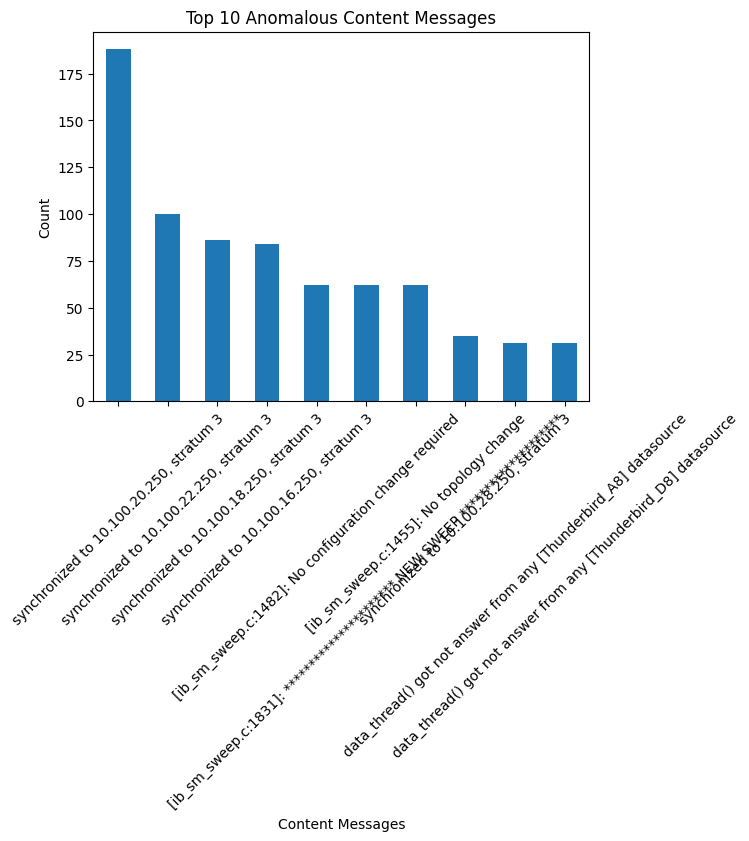

In [37]:
# Analyze the frequency of specific content
content_counts = top_anomalies['Content'].value_counts()
print(content_counts)

# Visualize the top content issues
import matplotlib.pyplot as plt

content_counts.head(10).plot(kind='bar')
plt.title('Top 10 Anomalous Content Messages')
plt.ylabel('Count')
plt.xlabel('Content Messages')
plt.xticks(rotation=45)
plt.show()

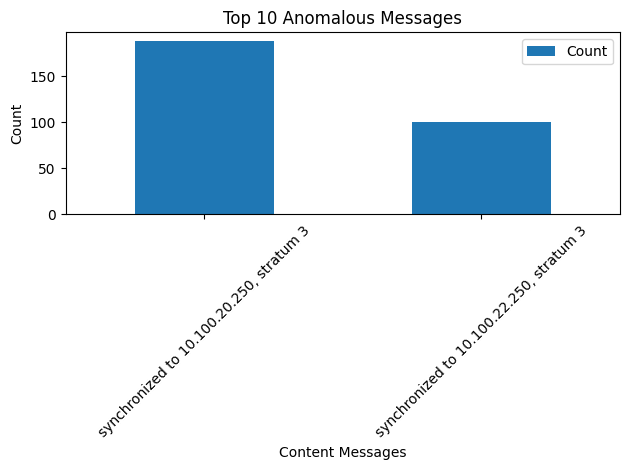

In [38]:
import matplotlib.pyplot as plt

# Assume 'content_counts' contains the counts of each unique anomaly
content_counts = {
    'synchronized to 10.100.20.250, stratum 3': 188,
    'synchronized to 10.100.22.250, stratum 3': 100,
    # Add other entries...
}

# Create a DataFrame for visualization
df_counts = pd.DataFrame(list(content_counts.items()), columns=['Content', 'Count'])

# Plot the top 10 anomalies
df_counts.sort_values(by='Count', ascending=False).head(10).plot(x='Content', y='Count', kind='bar')
plt.title('Top 10 Anomalous Messages')
plt.ylabel('Count')
plt.xlabel('Content Messages')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [50]:
print(X_train.dtypes)  # Check data types of each column
print(X_train.isnull().sum())  # Check for missing values
#print(X_train[X_train.applymap(lambda x: isinstance(x, str))].any(axis=1)])  # Find rows with string values
print(X_train[X_train.applymap(lambda x: isinstance(x, str)).any(axis=1)])  # Find rows with string values


LineId             int64
Label             object
Timestamp          int64
Date              object
User              object
Month             object
Day                int64
Time              object
Location          object
Component         object
PID              float64
Content           object
EventTemplate     object
dtype: object
LineId             0
Label              0
Timestamp          0
Date               0
User               0
Month              0
Day                0
Time               0
Location           0
Component          0
PID              209
Content            0
EventTemplate      0
dtype: int64
      LineId Label   Timestamp        Date          User Month  Day      Time  \
968      969     -  1131566931  2005.11.09         bn138   Nov    9  12:08:51   
240      241     -  1131566540  2005.11.09     tbird-sm1   Nov    9  12:02:20   
819      820     -  1131566849  2005.11.09  tbird-admin1   Nov    9  12:07:29   
692      693     -  1131566781  2005.11.09  tbird-a

/var/folders/ry/tqxg7fpj1yz3wzs610_9tg8w0000gn/T/ipykernel_45539/3576907574.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  print(X_train[X_train.applymap(lambda x: isinstance(x, str)).any(axis=1)])  # Find rows with string values


Shape of X: (1745, 13)
Shape of y: (1745,)


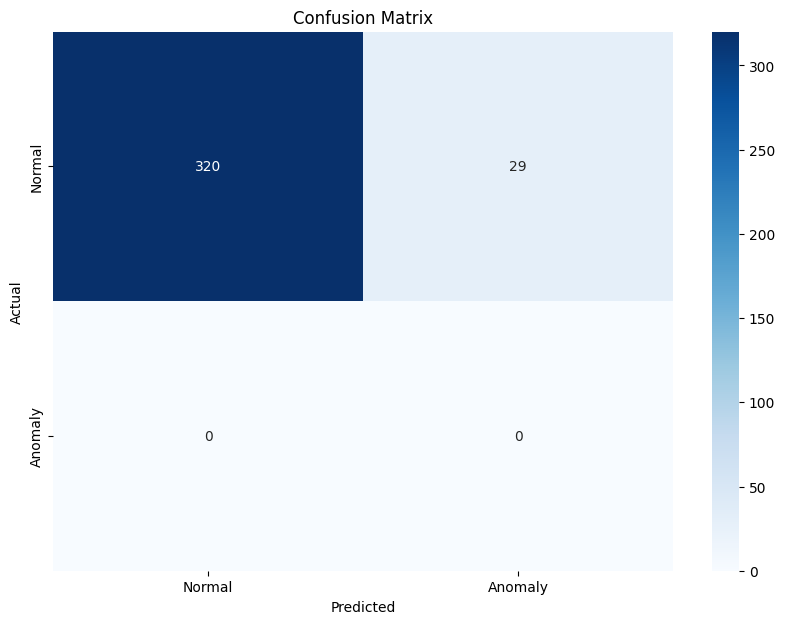

              precision    recall  f1-score   support

           0       1.00      0.92      0.96       349
           1       0.00      0.00      0.00         0

    accuracy                           0.92       349
   macro avg       0.50      0.46      0.48       349
weighted avg       1.00      0.92      0.96       349



/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [57]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Load your dataset
data = pd.read_csv('Thunderbird_2k.log_structured.csv')

# Define features and labels
X = data.drop('Label', axis=1)
y = data['Label']

# Replace '-' with NaN and drop rows with NaN values
X.replace('-', np.nan, inplace=True)
X.dropna(inplace=True)

# Align y with the filtered X
y = y[X.index]

# Check shapes
print("Shape of X:", X.shape)  # Check shape of X
print("Shape of y:", y.shape)  # Check shape of y

# Convert categorical columns to numeric
X = pd.get_dummies(X, drop_first=True)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Isolation Forest model
model = IsolationForest(contamination=0.1, random_state=42)
model.fit(X_train)

# Make predictions
y_pred = model.predict(X_test)
y_pred = [1 if pred == -1 else 0 for pred in y_pred]  # Convert predictions to 0 (normal) and 1 (anomaly)

# Ensure y_test is in the same binary format as y_pred
y_test = y_test.apply(lambda x: 1 if x == 'anomaly' else 0)  # Adjust based on your actual labels

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(y_test, y_pred))


In [58]:
from sklearn.metrics import accuracy_score

# ... [rest of your code]

# After making predictions
y_pred = model.predict(X_test)
y_pred = [1 if pred == -1 else 0 for pred in y_pred]

# Calculate and print the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')  # Print accuracy rounded to two decimal places

Accuracy: 0.92
